In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np

import jax.numpy as jnp
from jax import random, lax, jit, vmap, grad, partial, value_and_grad

from jax.experimental import optimizers

from util import progress_bar_scan, wait_until_computed, init_params
from optimisers import build_optimiser

# NN practice


See this [SO](https://stats.stackexchange.com/questions/364610/feedforward-neural-networks-for-regression-confusion) question for a discussion on NNs learning basis elements

NN with more depth

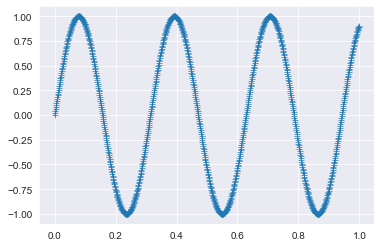

In [8]:
x_data = np.arange(0,1, 0.05)
Ndata = x_data.shape[0]
x_data = x_data.reshape(Ndata,1)
y_data = np.sin(x_data*10)



x_data = np.arange(0,1, 0.001)
Ndata = x_data.shape[0]
x_data = x_data.reshape(Ndata,1)
y_data = np.sin(x_data*20)

plt.plot(x_data, y_data, marker="+", alpha=.7, lw=0.6)

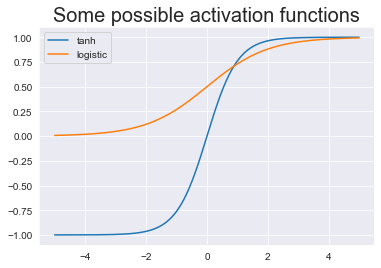

In [9]:
def logistic(x):
    return 1/(1+np.exp(-x))

myrange = np.arange(-5,5,0.01)

plt.title("Some possible activation functions", size=20)
plt.plot(myrange, np.tanh(myrange), label="tanh")
plt.plot(myrange, logistic(myrange), label="logistic")

plt.legend()

In [10]:
def predict(params, x):
    activation = x
    for W,b in params[:-1]:
        activation = jnp.tanh(jnp.dot(W, activation) + b)
    
    W_last, b_last = params[-1]
    return jnp.dot(W_last, activation) + b_last


batch_predict = vmap(predict, in_axes=(None, 0))

@jit
def loss_NN(params, x_data, y_data):
    preds = batch_predict(params, x_data)
    return jnp.mean(jnp.square(preds-y_data))

val_and_grad_loss_NN = jit(value_and_grad(loss_NN))


In [11]:
run_adam = build_optimiser(val_and_grad_loss_NN, "adam")
run_sgd = build_optimiser(val_and_grad_loss_NN, "sgd")

In [17]:
Niters = 100000
l_rate = 1e-2


key = random.PRNGKey(0)
M, D, K, L = 10, 1, 1, 2
params = init_params(key, M, D, K, L)

total_params = (D*M + M) + (M**2)*(L-2) + (M*K + K)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 31


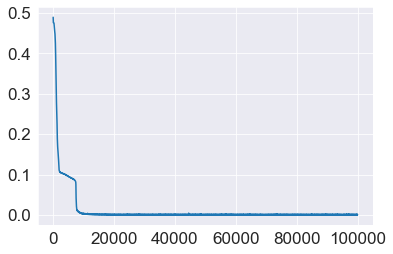

In [18]:
opt_params, array_loss = run_adam(Niters, l_rate, x_data, y_data, params)
# opt_params, array_loss = run_sgd(Niters, l_rate, x_data, y_data, params)

plt.plot(array_loss)

In [19]:
def build_phi(i):
    def phi(x):
        return np.tanh(opt_params[0][0][i]*x + opt_params[0][1][i])        
    return phi


phi_dict = {i: build_phi(i) for i in range(M)}

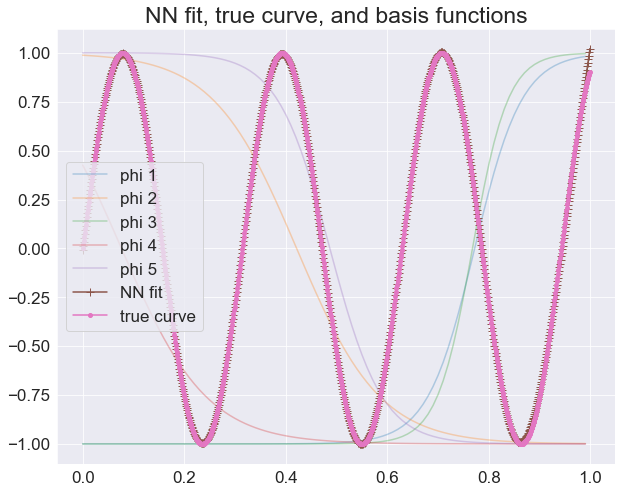

In [20]:
x_range = np.arange(0,1,0.01)[:, np.newaxis]


preds = batch_predict(opt_params, x_data)

plt.rcParams.update({"font.size":17})
plt.figure(figsize=(10,8))

for i in range(5):
    plt.plot(x_range, phi_dict[i](x_range), alpha=0.3, label=f"phi {i+1}")

plt.plot(x_data, preds, label="NN fit", marker="+", markersize=8)
plt.plot(x_data, y_data, label="true curve", marker="o", markersize=4)

plt.title("NN fit, true curve, and basis functions", size=23)
plt.legend()